DSC530: Week 11 \
11.2 Exercise \
Marty Hoehler \
5-26-24 

# Exercise 13-1
First, we'll download data and import libraries as outlined in the text.  We're bringing in both cycle 6 (2002 data) and cycle 7 (2010 data).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

import thinkstats2
import thinkplot

import numpy as np
import pandas as pd

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

import nsfg

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")

import survival

download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

In [2]:
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

Next, we will clean up the variables as recommended in the text.  The text also created "agemarry" and "age". 
These may be useful later, so I'll include them.
Note:  It appears that 'cmdivorcx' needs to be cleaned the same way cmmarrhx' needs to be, removing 9997, 9998, and 9999.

In [3]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6.cmdivorcx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0

resp7.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp7.cmdivorcx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp7["agemarry"] = (resp7.cmmarrhx - resp7.cmbirth) / 12.0
resp7["age"] = (resp7.cmintvw - resp7.cmbirth) / 12.0

Next, we'll calculate the duration of the marriages.  If a divorce didn't occur, we'll calculate the length of the marriage as of the date of the interview.
(Source for "np.where" function:  https://stackoverflow.com/questions/19913659/how-do-i-create-a-new-column-where-the-values-are-selected-based-on-existing-col)

In [4]:
resp6["divorced"] = -resp6['cmdivorcx'].isna()
resp7["divorced"] = -resp7['cmdivorcx'].isna()

resp6["marrdur"] = np.where(resp6['divorced'] == True, 
                            (resp6.cmdivorcx - resp6.cmmarrhx)/12.0, (resp6.cmintvw - resp6.cmmarrhx)/12.0) 

resp7["marrdur"] = np.where(resp7['divorced'] == True, 
                            (resp7.cmdivorcx - resp7.cmmarrhx)/12.0, (resp7.cmintvw - resp7.cmmarrhx)/12.0)

Since we are studying the length of marriages, we will filter the dataframe to only those respondants who have married.
We'll also concatenate the two datasets together.
(Concat() source:  https://pandas.pydata.org/docs/user_guide/merging.html)

#### Note:
It appears that there are some cases where 'evrmarry' is true, but there is no marriage date.  This causes errors in our marriage duration caculation, so we'll also remove lines where 'cmmarrhx' is NaN.

It also appears that there are some cases where the date of divorce is earlier than the date of marriage.  Since this doesn't make sense, we'll remove those as well.

In [5]:
resp6mar = resp6[resp6['evrmarry']==True]
resp7mar = resp7[resp7['evrmarry']==True]
resp6mar = resp6mar[resp6mar['cmmarrhx'].isna() == False]
resp7mar = resp7mar[resp7mar['cmmarrhx'].isna() == False]

resp6marD = resp6mar[(resp6mar['cmdivorcx']- resp6mar['cmmarrhx']) >= 0]  
resp6marM = resp6mar[resp6mar['divorced'] == False]
resp7marD = resp7mar[resp7mar['cmdivorcx']- resp7mar['cmmarrhx'] >= 0]
resp7marM = resp7mar[resp7mar['divorced'] == False]


resps = pd.concat([resp6marD, resp6marM, resp7marD, resp7marM], ignore_index=True)

resps

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,divorced,marrdur,wgtq1q16
0,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,True,8.583333,NaN
1,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,True,2.333333,NaN
2,11700,822,True,1015.0,1051.0,2,4666.559600,1236,16.083333,34.500000,68,6,13,True,3.000000,NaN
3,7354,896,True,1071.0,1178.0,5,3026.730179,1235,14.583333,28.250000,74,7,14,True,8.916667,NaN
4,5083,789,True,1064.0,1168.0,2,3374.535218,1236,22.916667,37.250000,65,6,13,True,8.666667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,26745,812,True,1155.0,NaN,2,5220.893454,1282,28.583333,39.166667,67,6,13,False,10.583333,5220.893454
9596,26914,985,True,1221.0,NaN,2,5152.498030,1282,19.666667,24.750000,82,8,16,False,5.083333,5152.498030
9597,30517,810,True,1107.0,NaN,3,2830.681441,1282,24.750000,39.333333,67,6,13,False,14.583333,2830.681441
9598,26372,771,True,1025.0,NaN,4,19328.779624,1286,21.166667,42.916667,64,6,12,False,21.750000,19328.779624


#### Define Functions
We will use the text's definition for EstimateHazard().

In [6]:
from collections import Counter


def EstimateHazardFunction(complete, ongoing, label="", verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)
 

Next, we define the "complete" and "ongoing" sets.  
- "Complete" is the duration for those who are divorced.
- "Ongoing" is the duration for those who are still married.

In [7]:
complete = resps[resps.divorced==True].marrdur
ongoing = resps[resps.divorced==False].marrdur

hf = EstimateHazardFunction(complete, ongoing)

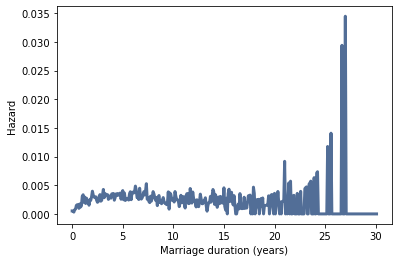

In [8]:
thinkplot.Plot(hf)
thinkplot.Config(xlabel="Marriage duration (years)", ylabel="Hazard")

Our text mentions that the hazard function can get over-estimated at the tail end, where there is less data available.  In this case, there are fewer respondants that have been married 25 or more years.  (It's rare for someone in a relationship that long to still be young enough to become pregnant.)  So the hazard function gets noisy at this area.

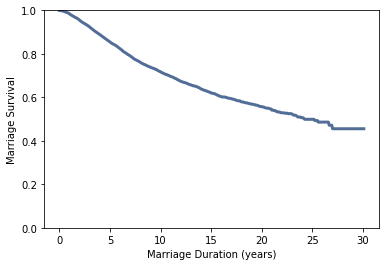

In [9]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel="Marriage Duration (years)", ylabel="Marriage Survival", ylim=[0, 1])

According to this survival function, marriages end at a fairly steady rate, but are slightly more likely between years 1-5.

### Resampling

We will use the text's ResampleSurvival() formula to resample the data to account for sampling error.  It needs to be adjusted slightly to use our 'marrdur' field instead of the 'agemarry' stat used in the book.

In [10]:
def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.marrdur.min(), resp.marrdur.max()
    ts = np.arange(low, high, 1 / 12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color="gray", label="90% CI")
    
def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.divorced==True].marrdur
    ongoing = resp[resp.divorced==False].marrdur

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

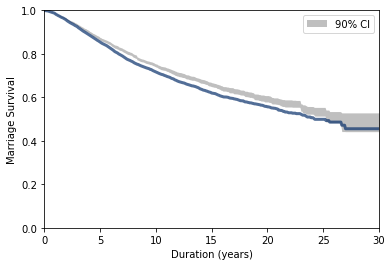

In [11]:
ResampleSurvival(resps)
thinkplot.Config(
    xlabel="Duration (years)",
    ylabel="Marriage Survival",
    xlim=[0, 30],
    ylim=[0, 1],
    loc="upper right",
)

This shows that the raw data is outside of the 90% confidence interval of the resampled data, which indicates that sampling error is having a strong effect on the results.

### Cohort Analysis

We will split our data into cohorts by decade of birth to see if marriage duration trends change throughout the generations.  We will addapt the formulas provided as examples in the book.  

#### Note:  
When the book is talking about "marriage survival" it means a survival funcion of how long a person remains unmarried... "surviving the state of being married".  In our work, we are studying the survival of the marriage itself.  So although the underlying statistic has changed, there's not a strong need to change the terminology, as long as we're clear what we mean by "marriage survival".

In [12]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = "%d0s" % name
        thinkplot.Plot([15], [1], label=label, **options)


def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)


def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)
            
def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i - 1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

This code requires that the index be maintained, so the concatenation I did above for "resps" won't work.  Instead, I'll create "respsList" which is a list of the four separate DFs, withe their indices intact.

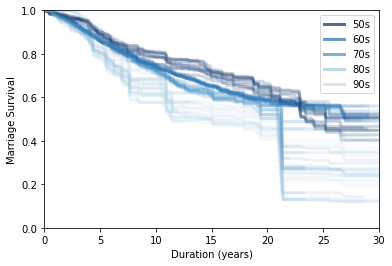

In [13]:
respsList = [resp6marD, resp6marM, resp7marD, resp7marM]

PlotResampledByDecade(respsList, predict_flag=True)
thinkplot.Config(
    xlabel="Duration (years)", ylabel="Marriage Survival", xlim=[0, 30], ylim=[0, 1]
)

Our code predicts how younger generations behave based on what the older generations did.  Even with that understanding, we see that older generations had a higher Marriage Survival rate.